[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel/fl-tutorial/blob/gh-pages/tutorial_notebooks/Tutorial_3_GaNDLF_OpenFL_tutorial.ipynb)

# Federated GaNDLF Tutorial with PathMNIST dataset
In this tutorial, we will be using the **Generally Nuanced Deep Learning Framework** (GaNDLF) to perform training and inference on a ResNet architecture, with PathMNIST, a dataset of colon pathology images, using [OpenFL](https://github.com/intel/openfl) in a federated learning fashion. This is a multi-class classification task: there are 9 different types of colon tissue displayed in the pathology images, each represented by its own class.

This tutorial demonstrates how to use GaNDLF with a simple classification task. Some steps that would ordinarily be part of the workflow (e.g. data CSV and config YAML file construction) have already been performed for simplicity; please refer to the [GaNDLF documentation](https://cbica.github.io/GaNDLF/) for more details on replication of these steps.

## Dependencies and Packages

Let's get these out of the way first.

In [1]:
# Use latest pip to avoid dependency issues
!python -m pip install -U pip
!(python -m pip install \
    pandas \
    matplotlib \
    torch==1.8.2 \
    torchvision==0.9.2 \
    --extra-index-url https://download.pytorch.org/whl/lts/1.8/cu111)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/lts/1.8/cu111
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.0/2.0 GB 54.3 MB/s eta 0:00:01tcmalloc: large alloc 1982201856 bytes == 0x3362000 @  0x7f452bab21e7 0x4a3940 0x4a39cc 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x511e2c 0x549576 0x593fce 0x511e2c 0x549576 0x593fce 0x511e2c 0x549576 0x593fce 0x511e2c 0x549576 0x593fce 0x511e2c 0x593dd7 0x511e2c 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x511e2c
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.0/2.0 GB 62.5 MB/s eta 0:00:01tcmalloc: large alloc 2477752320 bytes == 0x795c2000 @  0x

## 1. Familiarize yourself with the Dataset

MedMNIST is a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D. MedMNIST is designed to perform classification on lightweight 2D and 3D images with various data scales (from 100 to 100,000) and diverse tasks (binary/multi-class, ordinal regression and multi-label).

![Datasets in MedMNIST](https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/assets/medmnistv2.jpg)

Source: https://github.com/MedMNIST/MedMNIST

Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. "MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification". arXiv preprint arXiv:2110.14795, 2021.

### 1.1 Download PathMNIST Dataset

The tool will download all datasets. We're mainly interested in `pathmnist`. Feel free to interrupt the execution after it has downloaded `pathmnist`.

In [2]:
# Install medmnist package
!python -m pip install -q medmnist
!python -c "import medmnist; print('MEDMNIST: ', medmnist.__version__)"

# Download medmnist datasets
!python -m medmnist download

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
MEDMNIST:  2.1.0
205616128it [00:09, 21811443.79it/s]                   
82802688it [00:03, 21332359.58it/s]                  
19725312it [00:01, 12899504.99it/s]                  
54938624it [00:03, 18050886.09it/s]                  
4170752it [00:00, 4761710.82it/s]                 
3291136it [00:00, 3719207.58it/s]                 
560128it [00:00, 1018154.23it/s]                
35462144it [00:02, 16254286.80it/s]                  
124962816it [00:05, 22954049.82it/s]                   
38248448it [00:02, 15887087.63it/s]                  
15527936it [00:01, 10179566.07it/s]                  
16529408it [00:01, 12524799.55it/s]                  
32657408it [00:02, 14981069.78it/s]                  
29299712it [00:02, 13279774.81it/s]                  
277504it [00:00, 634810.31it/s]                
3278848it [00:00, 3699556.99it/s]                 
399360it [00:0

### 1.2 Convert to images

MedMNIST datasets come as a single consolidated `np.ndarray`. We will convert these to `png` images to allow us to use the dataset with `GaNDLF`, a deep learning framework for medical images.

In [3]:
# Convert dataset from numpy to *.png
!(python -m medmnist save \
  --flag=pathmnist \
  --folder=./medmnist/dataset/ \
  --postfix=png)

Saving pathmnist train...
100% 89996/89996 [00:35<00:00, 2521.61it/s]
Saving pathmnist val...
100% 10004/10004 [00:03<00:00, 2806.47it/s]
Saving pathmnist test...
100% 7180/7180 [00:02<00:00, 2839.11it/s]


### 1.3 Download `train`, `val` and `test` lists

These `csv` files are list of paths to `png` images created earlier, that will be partitioned into their respective splits.

In [4]:
%%bash
# Train CSV list
wget -q --show-progress -O ./medmnist/dataset/train_path_full.csv "https://app.box.com/index.php?rm=box_download_shared_file&shared_name=um4003lkrvyj55jm4a0jz7zsuokb0r8o&file_id=f_991821586980"
echo "Downloaded train list"

# Validation CSV list
wget -q --show-progress -O ./medmnist/dataset/val_path_full.csv "https://app.box.com/index.php?rm=box_download_shared_file&shared_name=rsmff27sm2z34r5xso1jx8xix7nhfspc&file_id=f_991817441206"
echo "Downloaded val list"

# Test CSV list
wget -q --show-progress -O ./medmnist/dataset/test_path_tiny.csv "https://app.box.com/index.php?rm=box_download_shared_file&shared_name=22lm0qfzk5luap72mtdpzx5l3ocflopa&file_id=f_991819617152"
echo "Downloaded test list"

Downloaded train list
Downloaded val list
Downloaded test list



     0K .......... .......... .......... .......... .......... 20%  514K 0s
    50K .......... .......... .......... .......... .......... 40%  790K 0s
   100K .......... .......... .......... .......... .......... 60% 1.28M 0s
   150K .......... .......... .......... .......... .......... 80% 1.84M 0s
   200K .......... .......... .......... .......... .......   100% 2.43M=0.2s
     0K .......... .......... .......... .......... .......... 88% 1.20M 0s
    50K ......                                                100% 1.42M=0.04s
     0K .......... .......... .........                       100%  380K=0.08s

We will be using this single-source of images for our Federated Learning experiment. 

To avoid duplication of data at multiple paths for the experiment, we update the paths in all CSVs to reflect full path instead of relative paths. Full path ensures it will be accessible from any location in our runtime.

Essentially, we update `./medmnist` to `/full/path/to/medmnist` in all the 3 CSV files.

In [5]:
import os
import shutil
import numpy as np
import pandas as pd

# Convert ALL paths in the CSV to Absolute paths
csv_files = {
    'train': './medmnist/dataset/train_path_full.csv',
    'val': './medmnist/dataset/val_path_full.csv',
    'test': './medmnist/dataset/test_path_tiny.csv'
}

for path in csv_files.values():
    with open(path, 'r') as f:
        content = f.read()
        content = content.replace('./medmnist', os.path.abspath('./medmnist'))
    
    with open(path, 'w') as f:
        f.write(content)
    print('Updated paths in ', path)

Updated paths in  ./medmnist/dataset/train_path_full.csv
Updated paths in  ./medmnist/dataset/val_path_full.csv
Updated paths in  ./medmnist/dataset/test_path_tiny.csv


### 1.4 Preview Sample Data

Let's use a bit of plotting to see what our data is like.

Below cell helps visualize a few images with their labels. 

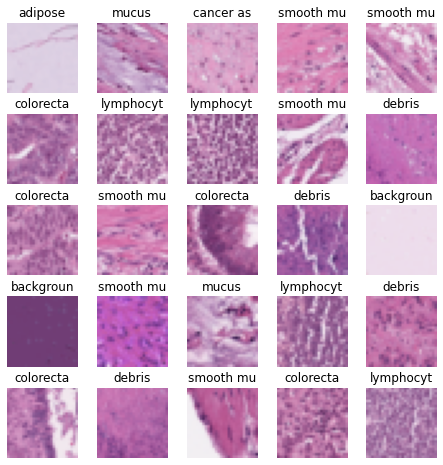

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

n_img = 5
train_samples = pd.read_csv(csv_files['train']).head(n_img*n_img)

label2str = [
    'adipose',
    'background',
    'debris',
    'lymphocytes',
    'mucus',
    'smooth muscle',
    'normal colon mucosa',
    'cancer associated stroma',
    'colorectal adenocarcinoma epithelium'
]

fig, ax = plt.subplots(n_img, n_img, figsize=(8, 8))

for k in range(len(train_samples)):
    i = k // n_img
    j = k % n_img
    filepath = train_samples.iloc[k]['Channel_0']
    label = train_samples.iloc[k]['valuetopredict']
    ax[i, j].imshow(Image.open(filepath))
    ax[i, j].title.set_text(label2str[label][:9])
    ax[i, j].axis('off')
fig.subplots_adjust(wspace=0.03, hspace=0.3)


## 2. Federated Learning

Let's install OpenFL and GaNDLF. This will let us train our models and run FL experiments.

Generally Nuanced Deep Learning Framework or GaNDLF is a generalizable application framework for segmentation, regression, and classification using PyTorch. It supports multiple deep learning model architectures, modalities and classes. 

Open Federated Learning (OpenFL) is a Deep Learning framework-agnostic Python3 library for federated learning that enables organizations to collaboratively train a model without sharing sensitive information. Training of statistical models may be done with any deep learning framework, such as TensorFlow or PyTorch, via a plugin mechanism. OpenFL is a community supported project, originally developed by Intel Labs and the Intel Internet of Things Group.

In [7]:
%%bash
# Install OpenFL
rm -rf openfl
git clone -b miccai_fl_tutorial https://github.com/intel/openfl.git
cd openfl
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/openfl
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

Cloning into 'openfl'...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.8.2+cu111 which is incompatible.
google-colab 1.0.0 requires tornado~=5.1.0, but you have tornado 6.2 which is incompatible.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.0.1 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [8]:
%%bash
# Download and install GaNDLF modules
rm -rf GaNDLF
git clone -b 0.0.14 --depth 1 https://github.com/CBICA/GaNDLF.git
cd GaNDLF
git submodule update --init --recursive
echo "Installing GANDLF"
python -m pip install .
python ./gandlf_verifyInstall

Submodule path 'GANDLF/OPM': checked out 'f46ce145128415b0baf893b4782294c90953f251'
Submodule path 'GANDLF/anonymize/dicomanonymizer': checked out '5193ca5409f397e637e4c1a6dfd8f86a09a3cfc4'
Installing GANDLF
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/GaNDLF
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.6/156.6 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.0/283.0 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━

Cloning into 'GaNDLF'...
Note: checking out 'bdf7c72c90a0ed0355c2c66ce940db3dac828997'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

Submodule 'GANDLF/OPM' (https://github.com/CBICA/OPM.git) registered for path 'GANDLF/OPM'
Submodule 'GANDLF/anonymize/dicomanonymizer' (https://github.com/KitwareMedical/dicom-anonymizer.git) registered for path 'GANDLF/anonymize/dicomanonymizer'
Cloning into '/content/GaNDLF/GANDLF/OPM'...
Cloning into '/content/GaNDLF/GANDLF/anonymize/dicomanonymizer'...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follo

In [9]:
# Verify installations
import sys
gandlf_src = os.path.abspath('./GaNDLF')
sys.path.insert(0, gandlf_src)                # For current kernel python runtime
if 'PYTHONPATH' not in os.environ:
    os.environ['PYTHONPATH'] = ''
os.environ['PYTHONPATH'] += f':{gandlf_src}'  # For shell-invoked python runtime

import GANDLF
print('GaNDLF', GANDLF.__version__)

import openfl
print('OpenFL', openfl.__version__)

GaNDLF 0.0.14
OpenFL 1.4


### 2.1 Create a Federated Learning Workspace

In [10]:
import os
import shutil

# Choose what you like
FL_WORKSPACE_NAME = 'miccai_fl_tutorial'
ROUNDS_TO_TRAIN = 2
BATCH_SIZE = 16
DEVICE = 'cpu'

# Create a blank directory with CSV files copied over
workspace_dir = os.path.abspath(os.path.join(os.getcwd(), FL_WORKSPACE_NAME))
if os.path.exists(workspace_dir):
    shutil.rmtree(workspace_dir)
os.mkdir(workspace_dir)

for file in csv_files.values():
    shutil.copy2(file, workspace_dir)
    print(f'Copied `{file}` to workspace `{workspace_dir}`')

Copied `./medmnist/dataset/train_path_full.csv` to workspace `/content/miccai_fl_tutorial`
Copied `./medmnist/dataset/val_path_full.csv` to workspace `/content/miccai_fl_tutorial`
Copied `./medmnist/dataset/test_path_tiny.csv` to workspace `/content/miccai_fl_tutorial`


In [11]:
# Create FL workspace from template
!fx workspace create --prefix $FL_WORKSPACE_NAME --template "gandalf_classification_test" 2>&1

Creating Workspace Directories
Creating Workspace Templates
INFO:openfl.federated.plan.plan:Loading DEFAULTS for section [red]aggregator[/] from file [red]/usr/local/lib/python3.7/dist-packages/openfl-workspace/workspace/plan/defaults/aggregator.yaml[/].
INFO:openfl.federated.plan.plan:Loading DEFAULTS for section [red]assigner[/] from file [red]/usr/local/lib/python3.7/dist-packages/openfl-workspace/workspace/plan/defaults/assigner.yaml[/].
INFO:openfl.federated.plan.plan:Loading DEFAULTS for section [red]collaborator[/] from file [red]/usr/local/lib/python3.7/dist-packages/openfl-workspace/workspace/plan/defaults/collaborator.yaml[/].
INFO:openfl.federated.plan.plan:Loading DEFAULTS for section [red]compression_pipeline[/] from file [red]/usr/local/lib/python3.7/dist-packages/openfl-workspace/workspace/plan/defaults/compression_pipeline.yaml[/].
INFO:openfl.federated.plan.plan:Loading DEFAULTS for section [red]data_loader[/] from file [red]/usr/local/lib/python3.7/dist-packages/openf

In [12]:
# Certify and Export the workspace
import socket
FQDN = 'localhost'
print(FQDN)
!(cd $workspace_dir &&\
  sed -i "/rounds_to_train/c\    rounds_to_train: $ROUNDS_TO_TRAIN" plan/plan.yaml &&\
  sed -i "/batch_size/c\      batch_size: $BATCH_SIZE" plan/plan.yaml &&\
  sed -i "/device/c\    device: $DEVICE" plan/plan.yaml &&\
  fx plan initialize -a $FQDN &&\
  fx workspace certify &&\
  fx workspace export) | tee 2>&1

localhost
INFO:openfl.federated.plan.plan:FL-Plan hash is [blue]ec17214b030f65281c431a1f14cbd633d79dd94ecb1c154c4fdd009e5eb6733e7a8d17f32dc812878ff0e6f19b57e05d[/]
INFO:openfl.federated.plan.plan:Parsing Federated Learning Plan : [green]SUCCESS[/] : [blue]/content/miccai_fl_tutorial/plan/plan.yaml[/].
INFO:openfl.federated.plan.plan:aggregator:
  settings:
    best_state_path: save/fets_seg_test_best.pbuf
    db_store_rounds: 2
    init_state_path: save/fets_seg_test_init.pbuf
    last_state_path: save/fets_seg_test_last.pbuf
    rounds_to_train: 2
    write_logs: true
  template: openfl.component.Aggregator
assigner:
  settings:
    task_groups:
    - name: train_and_validate
      percentage: 1.0
      tasks:
      - aggregated_model_validation
      - train
      - locally_tuned_model_validation
  template: openfl.component.RandomGroupedAssigner
collaborator:
  settings:
    db_store_rounds: 1
    delta_updates: false
    opt_treatment: RESET
  template: openfl.component.Collaborato

### 2.2 Simulating "Silos" of Data
The core idea behind Federated Learning, is to enable training across data silos, without sharing the data itself.

In this tutorial, we will "simulate" silos of data, by partitioning the training set into `N` parts, `N` is as many collaborators are to be simulated.

In real world, this is called Non-IID partitioning. But for simplicity purposes, we will equally partition our data into `N` parts.

Optionally, you could define your own partitioning scheme here.

Note: We assume your data is shuffled before partitioning. If not, you'd be simulating Non-IID conditions!

In [13]:
# Partition the dataset amongst as many collaborators
def data_split(data: np.ndarray, n: int):
    """Equally partition data into n parts"""
    return np.array_split(data, n)

In [14]:
collaborators = ['bob', 'charlie']  # Lowercase names are required
full_list_train = pd.read_csv(csv_files['train'])
train_partitions = data_split(full_list_train.values, n=len(collaborators))
full_list_val = pd.read_csv(csv_files['val'])
val_partitions = data_split(full_list_val.values, n=len(collaborators))

for i, col in enumerate(collaborators):
    # If it exists, clean up and create new
    col_path = os.path.abspath(os.path.join(col, FL_WORKSPACE_NAME))
    if os.path.exists(col_path):
        shutil.rmtree(col_path)
    os.makedirs(col_path)

    # Write train partition as a CSV
    col_list = pd.DataFrame(data=train_partitions[i], columns=full_list_train.columns.values)
    col_csv_path = os.path.join(col_path, 'train_path_full.csv')
    col_list.to_csv(col_csv_path, index=False)

    # Write val partition as a CSV
    col_list = pd.DataFrame(data=val_partitions[i], columns=full_list_val.columns.values)
    col_csv_path = os.path.join(col_path, 'val_path_full.csv')
    col_list.to_csv(col_csv_path, index=False)

    # Copy test/val partition as-is
    shutil.copy2(csv_files['test'], col_path)
    print(f'Train/Test/Val CSV for `{col}` written to {col_path}')

Train/Test/Val CSV for `bob` written to /content/bob/miccai_fl_tutorial
Train/Test/Val CSV for `charlie` written to /content/charlie/miccai_fl_tutorial


### 2.3 Registering Aggregators and Collaborators

This step involves generating certificates, registering them across one another, and preparing individual workspaces of the collaborators.

If you were to do this in a real-world Federation, same steps would apply individually across different devices.

In [15]:
%%bash
# Download config file for training/inference settings
wget -q --show-progress -O config.yaml "https://app.box.com/index.php?rm=box_download_shared_file&shared_name=hs0zwezggl4rxtzgrcaq86enu7qwuvqx&file_id=f_974251081617"

# This file will help plotting and visualizing our results
wget -q --show-progress -O gandlf_collectStats_final "https://app.box.com/index.php?rm=box_download_shared_file&shared_name=avq6pvqg3uzsc4uzbklab66mad6eaik5&file_id=f_989875069231"


     0K .........                                             100% 14.5M=0.001s
     0K .........                                             100% 16.8M=0.001s

In [16]:
# Get the path to archives
archive_path = os.path.join(workspace_dir, f'{FL_WORKSPACE_NAME}.zip')
data_path = './medmnist/dataset/pathmnist'

In [17]:
# Import workspace in each collaborator's path
for col in collaborators:
    col_path = os.path.abspath(col)
    col_workspace_path = os.path.join(col_path, FL_WORKSPACE_NAME)
    print('Collaborator: ', col)
    print('Importing workspace')
    !cd $col_path && fx workspace import --archive $archive_path >/dev/null
    
    print(f'Generating collaborator `{col}` certificate')
    !cd $col_workspace_path && fx collaborator generate-cert-request -n $col -d $data_path --silent
    col_cert_path = os.path.join(col_workspace_path, f'col_{col}_to_agg_cert_request.zip')
    !cd $workspace_dir && fx collaborator certify --request-pkg $col_cert_path --silent
  

Collaborator:  bob
Importing workspace
Generating collaborator `bob` certificate
Creating COLLABORATOR certificate key pair with following settings: CN=bob, SAN=DNS:bob
  Moving COLLABORATOR certificate to: /content/bob/miccai_fl_tutorial/cert/col_bob
Archive col_bob_to_agg_cert_request.zip with certificate signing request created
This file should be sent to the certificate authority (typically hosted by the aggregator) for signing

 ✔️ OK
The CSR Hash for file col_bob.csr = a1338776cd334d130724cd757eb33a5d990027c9bcc054a2329f13daf62d85d837624ceb1ce708cd7fd9a4dc55f8a328
 Signing COLLABORATOR certificate

Registering bob in /content/miccai_fl_tutorial/plan/cols.yaml

 ✔️ OK
Collaborator:  charlie
Importing workspace
Generating collaborator `charlie` certificate
Creating COLLABORATOR certificate key pair with following settings: CN=charlie, SAN=DNS:charlie
  Moving COLLABORATOR certificate to: /content/charlie/miccai_fl_tutorial/cert/col_charlie
Archive col_charlie_to_agg_cert_request.zi

In [18]:
# Generate certificate and key-pairs for talking to the aggregator
!cd $workspace_dir && fx aggregator generate-cert-request --fqdn $FQDN
!cd $workspace_dir && fx aggregator certify --fqdn $FQDN --silent

# Import these certificates to the collaborator (so that it can talk to the aggregator)
for col in collaborators:
    col_path = os.path.abspath(os.path.join(col, FL_WORKSPACE_NAME))
    agg_cert_path = os.path.join(workspace_dir, f'agg_to_col_{col}_signed_cert.zip')
    !cd $col_path && fx collaborator certify --import $agg_cert_path

Creating AGGREGATOR certificate key pair with following settings: CN=localhost, SAN=DNS:localhost
  Writing AGGREGATOR certificate key pair to: /content/miccai_fl_tutorial/cert/server

 ✔️ OK
The CSR Hash for file server/agg_localhost.csr = 0adb2d7006c9c922a66774855f7a004a4d554119243cbb9f774fac065ed10f1eb0654c16b67ec92a639007394f76f18c
 Signing AGGREGATOR certificate

 ✔️ OK
Certificate col_bob.crt installed to PKI directory

 ✔️ OK
Certificate col_charlie.crt installed to PKI directory

 ✔️ OK


### 2.4 Go!

In [19]:
os.environ['FL_WORKSPACE_NAME'] = FL_WORKSPACE_NAME

In [20]:
# Run first collaborator
%%bash
cd bob/$FL_WORKSPACE_NAME
fx collaborator start -n bob > log.log 2>&1 &

In [21]:
%%bash
# Run second collaborator
cd charlie/$FL_WORKSPACE_NAME
fx collaborator start -n charlie > log.log 2>&1 &

In [22]:
%%bash
# Start aggregator
cd $FL_WORKSPACE_NAME
fx aggregator start > log.log 2>&1 & 

### 2.5 Check progress

And wind down after a while.

In [24]:
# Stream aggregator logs
!tail -f $FL_WORKSPACE_NAME/log.log

METRIC:openfl.component.aggregator.aggregator:Round 1, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fefa3ec7750> train_accuracy:	0.040528
METRIC:openfl.component.aggregator.aggregator:Round 1, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fefa3ec7750> train_balanced_accuracy:	0.379989
METRIC:openfl.component.aggregator.aggregator:Round 1, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fefa3ec7750> train_classification_accuracy:	0.364750
METRIC:openfl.component.aggregator.aggregator:Round 1, aggregator: train <openfl.interface.aggregation_functions.weighted_average.WeightedAverage object at 0x7fefa3ec7750> train_f1:	0.037960
INFO:openfl.component.aggregator.aggregator:Saving round 2 model...
INFO:openfl.component.aggregator.aggregator:Sending signal to collaborator charlie to shutdown...
INFO:openfl.component.aggreg

In [112]:
%%bash
# Optional, kill all fx commands
ps -ax | grep fx
pkill fx

 475181 ?        Rl     2:56 /usr/bin/python3 /usr/local/bin/fx collaborator start -n bob
 475183 ?        Rl     2:54 /usr/bin/python3 /usr/local/bin/fx collaborator start -n charlie
 475185 ?        Sl     0:22 /usr/bin/python3 /usr/local/bin/fx aggregator start
 512444 ?        S      0:00 grep fx


# Exercises
Now that we have completed a federated experiment with OpenFL and GaNDLF, let's see how we can tune the experiment easily through the FL Plan file.

In [27]:
!cat miccai_fl_tutorial/plan/plan.yaml

aggregator:
  settings:
    best_state_path: save/fets_seg_test_best.pbuf
    db_store_rounds: 2
    init_state_path: save/fets_seg_test_init.pbuf
    last_state_path: save/fets_seg_test_last.pbuf
    rounds_to_train: 2
    write_logs: true
  template: openfl.component.Aggregator
assigner:
  settings:
    task_groups:
    - name: train_and_validate
      percentage: 1.0
      tasks:
      - aggregated_model_validation
      - train
      - locally_tuned_model_validation
  template: openfl.component.RandomGroupedAssigner
collaborator:
  settings:
    db_store_rounds: 1
    delta_updates: false
    opt_treatment: RESET
  template: openfl.component.Collaborator
compression_pipeline:
  settings: {}
  template: openfl.pipelines.NoCompressionPipeline
data_loader:
  settings:
    feature_shape:
    - 128
    - 128
  template: openfl.federated.data.loader_fets_challenge.FeTSChallengeDataLoaderWrapper
network:
  settings:
    agg_addr: localhost
    agg_port: 58252
    cert_folder: cert
    cli

# Exercise #1
One of the great things about GaNDLF is that with a single line change, you can modify just about any aspect of model training. Let's start with **changing the model** for the experiment. The default for the first experiment was `resnet18` (Cross Entropy Loss). For the list of options, see the built-in GaNDLF model options [here](https://github.com/CBICA/GaNDLF/blob/master/GANDLF/models/__init__.py)
TIP: `resnet34` and `efficientnetB0` are good options here

In [114]:
MODEL = 'ENTER THE MODEL HERE FOR EXERCISE 1'
# Reduce epochs from 5 -> 1 for faster training
NUM_EPOCHS = 1
ROUNDS_TO_TRAIN = 1 

In [115]:
# Reduce the number of epochs from 5 -> 1 to see faster results
!(cd $workspace_dir &&\
  sed -i "/rounds_to_train/c\    rounds_to_train: $ROUNDS_TO_TRAIN" plan/plan.yaml &&\
  sed -i "/num_epochs/c\      num_epochs: $NUM_EPOCHS" plan/plan.yaml &&\
  sed -i "/architecture/c\        architecture: $MODEL" plan/plan.yaml &&\
  sed -i "/base_filters/c\        base_filters: $BASE_FILTERS" plan/plan.yaml &&\
  cp plan/plan.yaml ../bob/miccai_fl_tutorial/plan/plan.yaml && \
  cp plan/plan.yaml ../charlie/miccai_fl_tutorial/plan/plan.yaml &&\
  fx plan initialize) | tee 2>&1

INFO:openfl.federated.plan.plan:FL-Plan hash is [blue]072c1ea212f353c350a3dd86cc9ffb5af4fb5b7be9b984e304261ee2ee6607f4e65ff4588558de55d8f4bde0e810c89b[/]
INFO:openfl.federated.plan.plan:Parsing Federated Learning Plan : [green]SUCCESS[/] : [blue]/content/miccai_fl_tutorial/plan/plan.yaml[/].
INFO:openfl.federated.plan.plan:aggregator:
  settings:
    best_state_path: save/fets_seg_test_best.pbuf
    db_store_rounds: 2
    init_state_path: save/fets_seg_test_init.pbuf
    last_state_path: save/fets_seg_test_last.pbuf
    rounds_to_train: 2
    write_logs: true
  template: openfl.component.Aggregator
assigner:
  settings:
    task_groups:
    - name: train_and_validate
      percentage: 1.0
      tasks:
      - aggregated_model_validation
      - train
      - locally_tuned_model_validation
  template: openfl.component.RandomGroupedAssigner
collaborator:
  settings:
    db_store_rounds: 1
    delta_updates: false
    opt_treatment: RESET
  template: openfl.component.Collaborator
compress

In [116]:
# Echo plan file to make sure change has taken effect
!cat $workspace_dir/plan/plan.yaml | grep architecture

        architecture: resnet34


## Run the Exercise 1 experiment

In [117]:
# Run first collaborator
%%bash
cd bob/$FL_WORKSPACE_NAME
fx collaborator start -n bob > log.log 2>&1 &

In [118]:
# Run first collaborator
%%bash
cd charlie/$FL_WORKSPACE_NAME
fx collaborator start -n charlie > log.log 2>&1 &

In [119]:
%%bash
# Start aggregator
cd $FL_WORKSPACE_NAME
fx aggregator start > log.log 2>&1 & 

In [ ]:
# Stream aggregator logs
!tail -f $FL_WORKSPACE_NAME/log.log

INFO:openfl.federated.plan.plan:FL-Plan hash is [blue]072c1ea212f353c350a3dd86cc9ffb5af4fb5b7be9b984e304261ee2ee6607f4e65ff4588558de55d8f4bde0e810c89b[/]
INFO:openfl.federated.plan.plan:Parsing Federated Learning Plan : [green]SUCCESS[/] : [blue]/content/miccai_fl_tutorial/plan/plan.yaml[/].
INFO:openfl.federated.plan.plan:aggregator:
  settings:
    best_state_path: save/fets_seg_test_best.pbuf
    db_store_rounds: 2
    init_state_path: save/fets_seg_test_init.pbuf
    last_state_path: save/fets_seg_test_last.pbuf
    rounds_to_train: 2
    write_logs: true
  template: openfl.component.Aggregator
assigner:
  settings:
    task_groups:
    - name: train_and_validate
      percentage: 1.0
      tasks:
      - aggregated_model_validation
      - train
      - locally_tuned_model_validation
  template: openfl.component.RandomGroupedAssigner
collaborator:
  settings:
    db_store_rounds: 1
    delta_updates: false
    opt_treatment: RESET
  template: openfl.component.Collaborator
compress

## Summary

We looked at GaNDLF, that internally takes care of model definition, training and validation loops; while OpenFL enables the infrastructure to aggregate models across participants.